# Service Optimization by Block

- There is a set of city blocks on a relatively small territory. 
- The problem is to determine the optimal location of services for one block for a limited number of Provision recalculations.

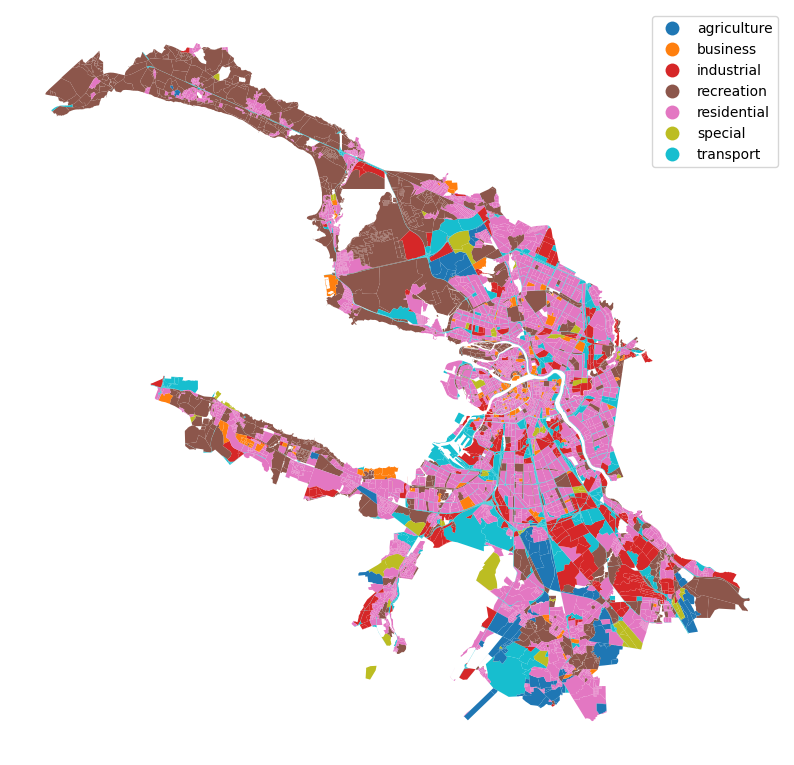

In [3]:
from blocksnet.models import City

city: City = City.from_pickle("model.pickle")

city.get_blocks_gdf(True).plot(column="land_use", legend=True, figsize=(10, 10)).set_axis_off()

Select ID of optimized blocks

In [5]:
blocks_ids = [10157]

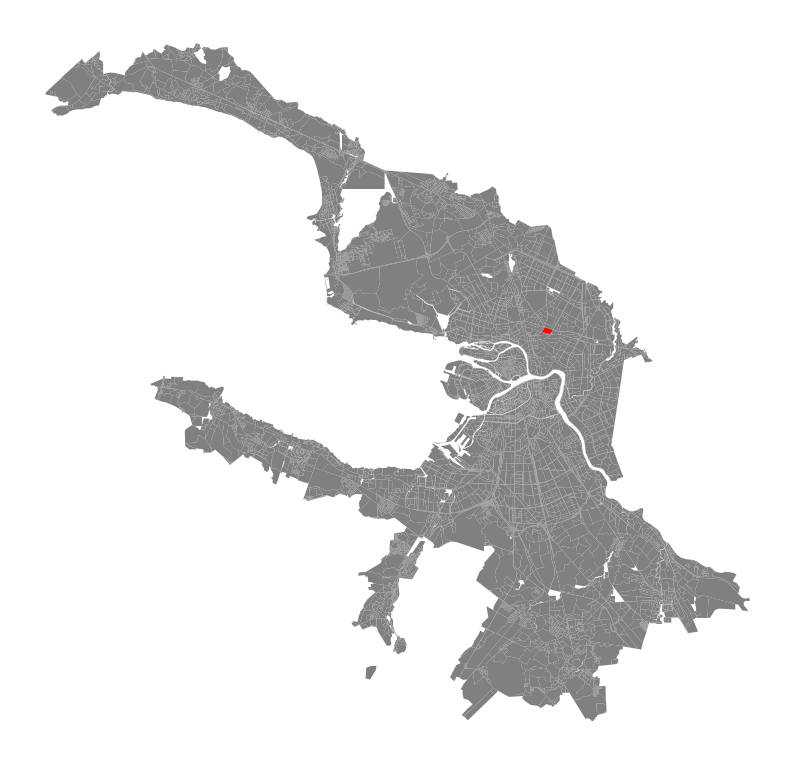

In [6]:
import numpy as np

city.get_blocks_gdf(True).plot(
    color=np.array(["red" if i in blocks_ids else "gray" for i in range(city.get_blocks_gdf().shape[0])]),
    legend=True,
    figsize=(10, 10),
).set_axis_off()

Generate blocks data for chosen IDs

In [7]:
from blocksnet.method.annealing_optimizer import LU_FSIS, LU_GSIS

blocks_lu = dict()
for block in city.blocks:
    if block.land_use is None or block.id not in blocks_ids:
        continue
    blocks_lu[block.id] = block.land_use

blocks_fsi = {b_id: LU_FSIS[lu][0] for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id: LU_GSIS[lu][0] for b_id, lu in blocks_lu.items()}

In [8]:
basic_services = [
    "kindergarten",
    "school",
    "pharmacy",
    "market",
    "cafe",
    "playground",
    "post",
    "hairdresser",
    "bus_stop",
    "parking",
]
advanced_services = [
    "polyclinics",
    "hospital",
    "supermarket",
    "restaurant",
    "park",
    "convenience",
    "bank",
    "fuel",
    "police",
]
comfort_services = ["mall", "dog_park", "swimming_pool", "train_station"]


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714
    elif service_name in advanced_services:
        return 0.2857
    elif service_name in comfort_services:
        return 0.1429
    return 0.1429

In [6]:
service_weights = {service_type.name: get_service_weight(service_type.name) for service_type in city.service_types}

In [8]:
from blocksnet.optimizer import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    BlocksNetFacade,
    BlockSolution,
    RandomOrder,
)

var_adapter = BlockSolution(city, blocks_lu)

facade = BlocksNetFacade(
    blocks_lu=blocks_lu, blocks_fsi=blocks_fsi, blocks_gsi=blocks_gsi, city_model=city, variable_adapter=var_adapter
)

objective = WeightedObjective(num_params=len(var_adapter), facade=facade, weights=service_weights, max_evals=30)

constraints = WeightedConstraints(num_params=len(var_adapter), facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective,
    constraints=constraints,
    vars_order=RandomOrder(),
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=10, timeout=600, initial_runs_num=1)

[I 2025-02-02 07:38:03,872] A new study created in memory with name: no-name-870885bf-a46a-498e-b1de-bbcd30a931e3


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-02-02 07:41:13,321] Trial 0 finished with value: 0.8506865510503693 and parameters: {'x_58': 0, 'x_21': 0, 'x_49': 1, 'x_33': 0, 'x_23': 0, 'x_25': 0, 'x_20': 1, 'x_65': 0, 'x_48': 1, 'x_59': 0, 'x_41': 0, 'x_8': 0, 'x_71': 0, 'x_22': 0, 'x_56': 0, 'x_24': 0, 'x_43': 0, 'x_57': 1, 'x_46': 0, 'x_28': 0, 'x_70': 0, 'x_34': 0, 'x_35': 0, 'x_4': 0, 'x_68': 0, 'x_69': 0, 'x_37': 1, 'x_60': 0, 'x_5': 0, 'x_2': 0, 'x_13': 1, 'x_12': 0, 'x_39': 0, 'x_17': 1, 'x_10': 0, 'x_61': 0, 'x_14': 0, 'x_1': 0, 'x_55': 0, 'x_44': 0, 'x_40': 0, 'x_18': 1, 'x_67': 1, 'x_15': 1, 'x_62': 0, 'x_45': 0, 'x_19': 1, 'x_52': 0, 'x_26': 0, 'x_50': 0, 'x_7': 0, 'x_11': 1, 'x_16': 1, 'x_3': 0, 'x_38': 0, 'x_32': 0, 'x_64': 1, 'x_29': 0, 'x_6': 0, 'x_72': 1, 'x_31': 0, 'x_54': 0, 'x_53': 1, 'x_51': 1, 'x_73': 0, 'x_0': 1, 'x_27': 0, 'x_63': 0, 'x_66': 1, 'x_36': 0, 'x_47': 0, 'x_9': 0, 'x_42': 0, 'x_30': 0}. Best is trial 0 with value: 0.8506865510503693.


In [8]:
import pandas as pd

tpe_df = pd.read_csv("tpe_trials.csv")

In [9]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

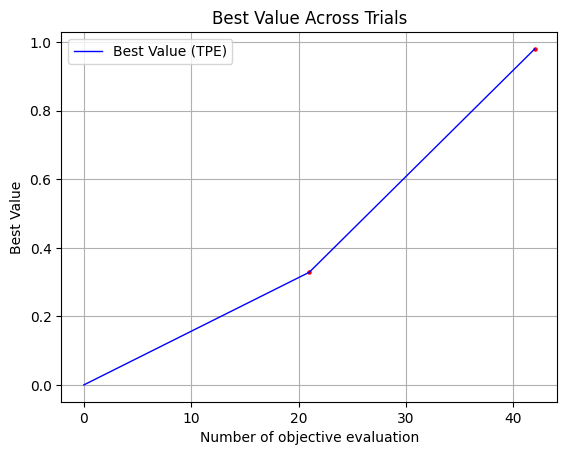

In [10]:
plot_df(tpe_df)